In [1]:
import os
import sys
from pathlib import Path

# current_path = os.getcwd()
# repo_dir = Path(current_path).parents[0]
# data_dir = repo_dir / 'data'
# if repo_dir not in sys.path:
#     sys.path.append(repo_dir)
    
repo_dir = os.path.abspath(os.path.join('..'))
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

import argparse
from functools import partial
import json
from keras import optimizers


from toolbox.data import load_set
from toolbox.models import get_model
from toolbox.experiment import Experiment
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.engine.topology import Layer
import tensorflow as tf
from keras.layers import Conv2D
from keras.layers import InputLayer
from keras import backend as K

import pandas as pd

import time

Using TensorFlow backend.


# Using Class

In [11]:
param_file = Path(repo_dir) / 'experiments' /'srcnn-9-1-5-sc4.json'
param = json.load(param_file.open())

scale = param['scale']
build_model = partial(get_model(param['model']['name']),
                      **param['model']['params'])

if 'optimizer' in param:
    optimizer = getattr(optimizers, param['optimizer']['name'].lower())
    optimizer = optimizer(**param['optimizer']['params'])
else:
    optimizer = 'adam'

load_set = partial(load_set,
                   lr_sub_size=param['lr_sub_size'],
                   lr_sub_stride=param['lr_sub_stride'])

expt = Experiment(scale=param['scale'], load_set=load_set,
                  build_model=build_model,optimizer=optimizer,
                  save_dir=param['save_dir'])


# repo_dir = Path(__file__).parents[1]
# data_dir = repo_dir / 'data' /'mytest' / '1.jpg'



In [13]:
image_dir = Path(repo_dir) / 'data' /'mytest' / '4.jpg'
expt.test_on_image(path = str(image_dir), prefix = '1', suffix = 'png')
print(expt.config_file)
prefix = str(expt.history_file).rsplit('.', maxsplit=1)[0]
prefix
expt.history_file

srcnn-9-1-5-sc4/config.yaml


PosixPath('srcnn-9-1-5-sc4/train/history.csv')

# Using method

In [167]:
def generate_sub_images(image, size, stride):
    for i in range(0, image.size[0] - size + 1, stride):
        for j in range(0, image.size[1] - size + 1, stride):
            yield image.crop([i, j, i + size, j + size])
            
def array_to_img(x, mode='YCbCr'):
    if mode == 'gray':
        return Image.fromarray(x.astype('uint8')).convert('RGB')
    else:
        return Image.fromarray(x.astype('uint8'), mode=mode).convert('RGB')



def bicubic_rescale(image, scale):
    if isinstance(scale, (float, int)):
        size = (np.array(image.size) * scale).astype(int)
    return image.resize(size, resample=Image.BICUBIC)

def img_downscale(image, scale = 4):
    if len(image.shape)==3: # color image
        down_size = np.int64(np.array(image.shape[0:2])/scale)
        img_downscale = np.zeros(np.append(down_size, image.shape[2]))
        for x in range(down_size[0]): #row
            for y in range(down_size[1]): # column
                X = x * scale
                Y = y * scale
                img_downscale[x, y] = image[X,Y]
        return img_downscale
    else: # gray_scale
        down_size = np.uint8(np.array(image.shape)/scale)
        img_downscale = np.zeros(down_size)
        for x in range(down_size[0]): #row
            for y in range(down_size[1]): # column
                X = x * scale
                Y = y * scale
                img_downscale[x, y] = image[X,Y]
        return img_downscale


def modcrop(image, scale):
    size = np.array(image.size)
    size -= size % scale
    return image.crop([0, 0, *size])

def load_set(name, lr_sub_size=11, lr_sub_stride=5, scale=3):
    hr_sub_size = lr_sub_size * scale
    hr_sub_stride = lr_sub_stride * scale
    lr_sub_arrays = []
    hr_sub_arrays = []
    for path in (data_dir / name).glob('*'):        
        image = load_img(path)
        image = image.convert('YCbCr')
        hr_image = modcrop(image, scale)
        lr_image = bicubic_rescale(hr_image, 1 / scale)
        lr_sub_arrays += [img_to_array(img) for img in generate_sub_images(lr_image, size=lr_sub_size, stride=lr_sub_stride)]
        hr_sub_arrays += [img_to_array(img) for img in generate_sub_images(hr_image, size=hr_sub_size, stride=hr_sub_stride)]
    x = np.stack(lr_sub_arrays)
    y = np.stack(hr_sub_arrays)
    return x, y

def ensure_dimension(array, dim):
    while len(array.shape) < dim:
        array = array[np.newaxis, ...]
    return array

def ensure_channel(array, c):
    return array[..., c:c+1]

def pre_process(array):
    array = ensure_dimension(array, 4)
    array = ensure_channel(array, 0)
    return array

def post_process(array, auxiliary_array):
    array = np.concatenate([array, auxiliary_array[..., 1:]], axis=-1)
    array = np.clip(array, 0, 255)
    return array

def inverse_post_process(array):
    array = ensure_dimension(array, 4)
    array = ensure_channel(array, 0)
    return array

In [168]:


class ImageRescale(Layer):
    def __init__(self, scale, method=tf.image.ResizeMethod.BICUBIC,
                 trainable=False, **kwargs):
        self.scale = scale
        self.method = method
        super().__init__(trainable=trainable, **kwargs)

    def compute_size(self, shape):
        size = np.array(shape)[[1, 2]] * self.scale
        return tuple(size.astype(int))

    def call(self, x):
        size = self.compute_size(x.shape.as_list())
        return tf.image.resize_images(x, size, method=self.method)

    def compute_output_shape(self, input_shape):
        size = self.compute_size(input_shape)
        return (input_shape[0], *size, input_shape[3])

    def get_config(self):
        config = super().get_config()
        config['scale'] = self.scale
        config['method'] = self.method
        return config

def bicubic(x, scale=3):
    model = Sequential()
    model.add(InputLayer(input_shape=x.shape[-3:]))
    model.add(ImageRescale(scale, method=tf.image.ResizeMethod.BICUBIC))
    return model

def srcnn(x, f=[9, 1, 5], n=[64, 32], scale=3):
    assert len(f) == len(n) + 1
    model = bicubic(x, scale=scale)
    c = x.shape[-1]
    for ni, fi in zip(n, f):
        model.add(Conv2D(ni, fi, padding='same',
                         kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(c, f[-1], padding='same',
                     kernel_initializer='he_normal'))
    return model

def psnr(y_true, y_pred):
    """Peak signal-to-noise ratio averaged over samples and channels."""
    mse = K.mean(K.square(y_true - y_pred), axis=(-3, -2))
    return K.mean(20 * K.log(255 / K.sqrt(mse)) / np.log(10))

def print_statistic(gx):
    print('Image shape is :' + str(gx.shape))
    print('Image range from %f to %f' % (np.amin(gx), np.amax(gx)))
    print('The length of the range is %f' % np.ptp(gx))
    print('data type is ' + str(gx.dtype))


In [ ]:
data_dir = Path(repo_dir) / 'data'
train_set='91-image'
val_set='Set5'

scale = 4;
lr_sub_size = 11
lr_sub_stride = 5
hr_sub_size = lr_sub_size * scale # 33
hr_sub_stride = lr_sub_stride * scale # 15




train_dir = save_dir / 'train'
train_dir.mkdir(exist_ok=True)
weights_dir = train_dir / 'weights'
weights_dir.mkdir(exist_ok=True)




latest_epoch = pd.read_csv(str(history_file))['epoch'].iloc[-1]



In [177]:
# x_train, y_train = load_set(train_set)
# x_val, y_val = load_set(val_set)
# x_train, x_val = [pre_process(x) for x in [x_train, x_val]]
# y_train, y_val = [inverse_post_process(y) for y in [y_train, y_val]]

def test_one_image_srcnn(data_dir, file_name, scale = 4):
    image_dir = data_dir / file_name
    param_file = Path(repo_dir) / 'experiments' /'srcnn-9-1-5-sc4.json'
    param = json.load(param_file.open())
    
    save_dir = Path(repo_dir) / 'experiments' / 'srcnn-9-1-5-sc4' / 'test' / 'mytest'
    save_dir.mkdir(parents=True, exist_ok=True)

    model_file = Path(repo_dir) / 'experiments' / 'srcnn-9-1-5-sc4' / 'model.hdf5'
    optimizer = 'adam'
    
    image = load_img(image_dir)
    image = image.convert('YCbCr')
    hr_image = modcrop(image, scale)
    hr_image.convert('RGB').save(str(save_dir / ('hr_' + file_name)))
    lr_image = bicubic_rescale(hr_image, 1 / scale)   
#     lr_image = array_to_img(img_downscale(img_to_array(hr_image), scale))  
    lr_image.convert('RGB').save(str(save_dir / ('lr_' + file_name)))
    
    x = img_to_array(lr_image)[np.newaxis, ...]
    bicubic_model = bicubic(x, scale=scale)
    y = bicubic_model.predict_on_batch(x)
    bicubic_array = np.clip(y[0], 0, 255)
    y_bicubic = array_to_img(bicubic_array)
    y_bicubic.save(str(save_dir / ('bicubic_' + file_name)))
    
    x_gray = pre_process(x)
    model = srcnn(x_gray, **param['model']['params'], scale = param['scale'])
    if model_file.exists(): 
        model.load_weights(str(model_file))
    model.compile(optimizer=optimizer, loss='mse', metrics=[psnr])
    # model.summary()


    start = time.perf_counter()
    y_pred = model.predict_on_batch(x_gray)
    end = time.perf_counter()
    
    # output_array = post_process(y_pred[0], bicubic_array)
    output_array = np.concatenate([y_pred[0], bicubic_array[..., 1:]], axis=-1)
    output_array = np.clip(output_array, 0, 255)
    output_image = array_to_img(output_array, mode='YCbCr')
    output_image.save(str(save_dir / ('srcnn_'+file_name)))
    
    row = pd.Series()
    row['name'] = image_dir.stem
    row['time'] = end - start
    y_true = inverse_post_process(img_to_array(hr_image))
    metrics=[psnr]
    for metric in metrics:
        row[metric.__name__] = K.eval(metric(y_true, y_pred))
    return row

In [24]:
data_dir = Path(repo_dir) / 'data' / 'mytest'
file_name = '4.jpg'
row = test_one_image_srcnn(data_dir, file_name, scale = 4)

In [25]:
row

name          4
time    1.38642
psnr    21.0684
dtype: object

## Visualization of SRCNN

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_rescale_2 (ImageRescal (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      5248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 32)      2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 1)       801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [59]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


In [60]:
layer_outputs

[<tf.Tensor 'image_rescale_4/resize/ResizeBicubic:0' shape=(?, 512, 512, 1) dtype=float32>,
 <tf.Tensor 'conv2d_4/Relu:0' shape=(?, 512, 512, 64) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu:0' shape=(?, 512, 512, 32) dtype=float32>,
 <tf.Tensor 'conv2d_6/BiasAdd:0' shape=(?, 512, 512, 1) dtype=float32>]

In [61]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
image_rescale_4 (ImageRescal (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 64)      5248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 32)      2080      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 512, 512, 1)       801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [62]:
print_statistic(x_gray)
x_gray /= 255.
print_statistic(x_gray)

Image shape is :(1, 128, 128, 1)
Image range from 21.000000 to 237.000000
The length of the range is 216.000000
data type is float32
Image shape is :(1, 128, 128, 1)
Image range from 0.082353 to 0.929412
The length of the range is 0.847059
data type is float32


In [63]:
activations = activation_model.predict(x_gray)

In [89]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 512, 512, 1)


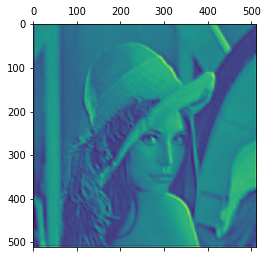

In [67]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [71]:
import keras
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)
images_per_row = 16

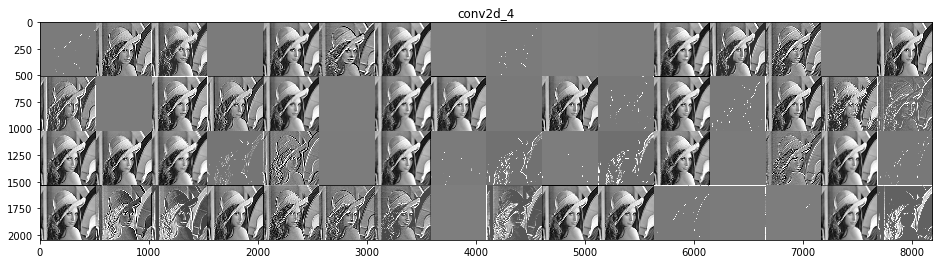

In [164]:
layer_activation = activations[1]
layer_name = layer_names[1]

n_features = layer_activation.shape[-1]
size = layer_activation.shape[1]
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image
# Display the grid（显示网格）
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='gray')


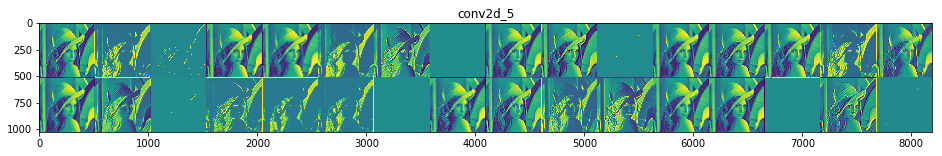

In [85]:
layer_activation = activations[2]
layer_name = layer_names[2]

n_features = layer_activation.shape[-1]
size = layer_activation.shape[1]
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image
# Display the grid（显示网格）
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')


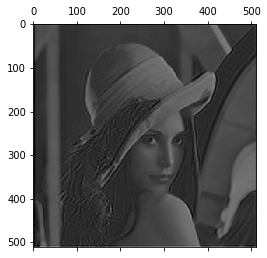

In [91]:
plt.matshow(activations[3][0, :, :, 0], cmap='gray')

In [94]:
print_statistic(activations[3][0, :, :, 0])

Image shape is :(512, 512)
Image range from 0.347835 to 1.985527
The length of the range is 1.637692
data type is float32


## Visualize max activation input (failed)

In [121]:
layer_name = layer_names[1]
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [122]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 128, 128, 1))])

In [123]:
input_img_data = np.random.random((1, 128, 128, 1)) * 20 + 128.
# Run gradient ascent for 40 steps（运行 40 次梯度上升）
step = 1.  # this is the magnitude of each gradient update（每次梯度更新的步长）
for i in range(40):
    # Compute the loss value and gradient value（计算损失值和梯度值）
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
#  沿着让损失最大化的 方向调节输入图像   
    input_img_data += grads_value * step

In [124]:
input_img_data.shape

(1, 128, 128, 1)

In [126]:
img = input_img_data[0]
img = deprocess_image(img)
print_statistic(img)


Image shape is :(128, 128, 1)
Image range from 71.000000 to 255.000000
The length of the range is 184.000000
data type is uint8


(128, 128, 1)

In [161]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
#     对张量做标准化，使其均值为 0， 标准差为 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]（将 x 裁切（clip）到 [0, 1] 区间）
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array（将 x 转换为 RGB 数组）
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def generate_pattern(layer_name, filter_index, size=128):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
#     构建一个损失函数，将该层第 n 个过滤器的激活最大化
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
#     计算这个损失相对于输入图像的梯度
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
#     标准化技巧：将梯度标准化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
#     返回给定输入图像的损失和梯度
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise（从带有噪声的灰度图像开始）
#     input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.
    input_img_data = np.ones((1, size, size, 1))
    # Run gradient ascent for 40 steps（运行 40 次梯度上升）
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0,:,:,0]
    return deprocess_image(img)

In [ ]:
plt.imshow(generate_pattern(layer_names[1], 0), cmap='gray')

In [ ]:
size = 128
margin = 5
layer_name = layer_names[1]
# This a empty (black) image where we will store our results.
#     空图像（全黑色）， 用于保存结果
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin))

for i in range(8):  # iterate over the rows of our results grid（遍历 results 网格的行）
    for j in range(8):  # iterate over the columns of our results grid（遍历 results 网格的列）
        # Generate the pattern for filter `i + (j * 8)` in `layer_name`
#             生成 layer_name 层第 i +（j * 8）个过滤器的模式

        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        print(i+(j*8))
        # Put the result in the square `(i, j)` of the results grid
        #  将结果放到 results 网格第 (i, j) 个方块中

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img

# Display the results grid（显示 results 网格）
plt.figure(figsize=(20, 20))
plt.imshow(results, cmap = 'gray')

## directly show the filter

In [193]:
cnn_filter_1 = model.get_weights()[0][:,:,0,:]

In [182]:
print_statistic(cnn_filter_1[:,:,1])

Image shape is :(9, 9)
Image range from -0.324352 to 0.328622
The length of the range is 0.652975
data type is float32


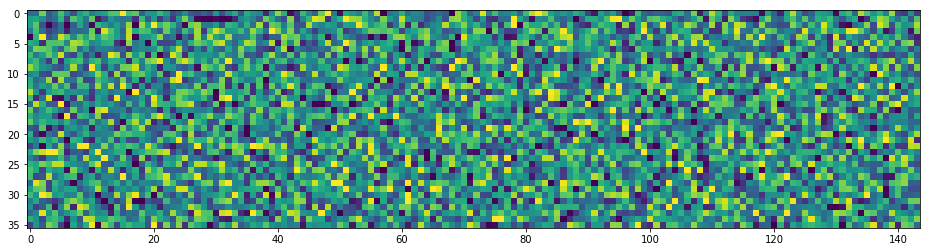

In [184]:
n_filters = cnn_filter_1.shape[-1]
size = cnn_filter_1.shape[1]
images_per_row = 16
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = cnn_filter_1[:, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image
# Display the grid（显示网格）
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [212]:
np.set_printoptions(edgeitems = 11, linewidth = 200)
results

array([[119., 119., 200., 103., 127., 185., 136.,  99., 157., 255., 255., ..., 255., 255., 146., 129., 201.,  47.,  74., 138., 100., 126., 112.],
       [159., 164., 143., 108., 121., 174.,  87., 189., 166., 255., 255., ..., 255., 255., 189., 214., 128., 132.,  46., 133., 159.,  73., 107.],
       [159., 191., 101.,  46.,  90., 125.,   0., 109., 165., 255., 255., ..., 255., 255., 106., 131., 127.,  12., 142.,  14., 110., 158., 218.],
       [129., 184., 121.,  88., 103., 124.,  69., 117., 116., 255., 255., ..., 255., 255., 180.,  49.,  47., 131., 136., 120., 195.,  47., 125.],
       [ 49., 176., 255., 102., 125., 227., 195., 141., 190., 255., 255., ..., 255., 255., 108.,  78., 134.,   3.,  73., 151.,  14., 186.,  63.],
       [169., 160.,  77., 188., 187., 190., 140., 217., 208., 255., 255., ..., 255., 255.,  72., 115.,  57., 117.,  74., 158.,  44., 128.,  59.],
       [140., 203., 198., 189., 146., 110., 189., 206., 118., 255., 255., ..., 255., 255.,  41., 152.,  94., 153., 173., 128

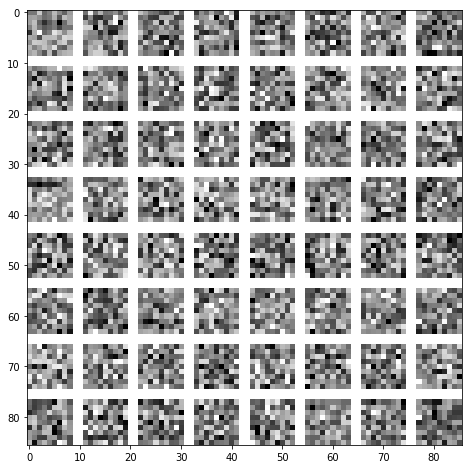

In [211]:
size = 9
margin = 2
results = np.ones((8 * size + 7 * margin, 8 * size + 7 * margin))*255

for i in range(8):  # iterate over the rows of our results grid（遍历 results 网格的行）
    for j in range(8):  # iterate over the columns of our results grid（遍历 results 网格的列）
        # Generate the pattern for filter `i + (j * 8)` in `layer_name`
#             生成 layer_name 层第 i +（j * 8）个过滤器的模式

        filter_img = cnn_filter_1[:,:,i + (j * 8)]
        filter_img = (filter_img - np.min(filter_img))
        filter_img = filter_img / np.max(filter_img)
        filter_img = np.uint8(filter_img*255)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img

# Display the results grid（显示 results 网格）
plt.figure(figsize=(8, 8))
plt.imshow(results, cmap = 'gray')

In [191]:
model.get_weights()[4].shape

(5, 5, 32, 1)

## manual image

In [169]:
img_manual = np.zeros((32,32))
for x in range(len(img_manual)):
    for y in range(len(img_manual)):
        if 1.5 * x - y < 2 and 1.5 * x - y > -2:
            img_manual[x,y] = 255
            
data_dir = Path(repo_dir) / 'data' / 'mytest'
file_name = '5.png'
img = array_to_img(img_manual, mode ='gray')
img.save(str(data_dir / file_name))

In [170]:
image = load_img(data_dir / file_name)
image = image.convert('YCbCr')

In [ ]:
# hr_image = modcrop(image, scale)
np.set_printoptions(edgeitems = 10, linewidth = 200)
img_to_array(image)[:,:,0]

In [179]:
data_dir = Path(repo_dir) / 'data' / 'mytest'
file_name = '5.png'
row = test_one_image_srcnn(data_dir, file_name, scale = 4)

In [61]:
row

name           5
time    0.119673
psnr     15.0051
dtype: object

In [235]:

img_manual_sr = (img_manual_sr - np.min(img_manual_sr))
img_manual_sr = img_manual_sr / np.max(img_manual_sr)
img_manual_sr = np.uint8(img_manual_sr*255)




In [250]:
Image.fromarray(img_manual[0,:,:,0].astype('uint8')).show()

In [249]:
Image.fromarray(img_manual_sr[0,:,:,0].astype('uint8')).show()

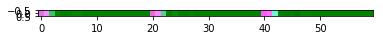

In [238]:
plt.imshow(output_image)

# HEVC Subpixel interpolation

In [18]:
def hevc_gray_upscale(img_gray):
    img_gray = np.int64(img_gray) -127
    
    taps14 = np.array([-1,4,-10,58,17,-5,1])
    taps12 = np.array([-1,4,-11,40,40,-11,4,-1])
    taps34 = np.flip(taps14)
    scale = 4
    datatype = np.int64
    # pad zeros to the side
    pad_zero_left = np.zeros((img_gray.shape[0], 3), dtype=datatype)
    pad_zero_right = np.zeros((img_gray.shape[0], 4), dtype=datatype)
    img_gray_pad = np.c_[pad_zero_left, img_gray, pad_zero_right]

    pad_zero_up = np.zeros((3, img_gray_pad.shape[1]), dtype=datatype)
    pad_zero_down = np.zeros((4, img_gray_pad.shape[1]), dtype=datatype)
    img_gray_pad = np.r_[pad_zero_up, img_gray_pad, pad_zero_down]

    img_upscale = np.zeros(np.array(img_gray_pad.shape) * scale, dtype=datatype)

    # pixel interpolated using original image
    for x in range(3, img_gray_pad.shape[0] - 4): #row
        for y in range(3, img_gray_pad.shape[1] - 4): # column
            X = x * scale
            Y = y * scale

            img_upscale[X, Y] = img_gray_pad[x,y] * 64
            img_upscale[X, Y + 1] = np.sum(np.multiply(taps14, img_gray_pad[x, y-3:y+4]))
            img_upscale[X, Y + 2] = np.sum(np.multiply(taps12, img_gray_pad[x, y-3:y+5]))
            img_upscale[X, Y + 3] = np.sum(np.multiply(taps34, img_gray_pad[x, y-2:y+5]))
            img_upscale[X + 1, Y] = np.sum(np.multiply(taps14, img_gray_pad[x-3:x+4, y]))
            img_upscale[X + 2, Y] = np.sum(np.multiply(taps12, img_gray_pad[x-3:x+5, y]))
            img_upscale[X + 3, Y] = np.sum(np.multiply(taps34, img_gray_pad[x-2:x+5, y]))

    # pixel interpolated in the middle
    for x in range(3, img_gray_pad.shape[0] - 4): #row
        for y in range(3, img_gray_pad.shape[1] - 4): # column    
            X = x * scale
            Y = y * scale
            img_upscale[X + 1, Y + 1] = np.right_shift(np.sum(np.multiply(taps14, img_upscale[X-3*scale : X+4*scale : scale, Y + 1])), 6)
            img_upscale[X + 1, Y + 2] = np.right_shift(np.sum(np.multiply(taps14, img_upscale[X-3*scale : X+4*scale : scale, Y + 2])), 6)
            img_upscale[X + 1, Y + 3] = np.right_shift(np.sum(np.multiply(taps14, img_upscale[X-3*scale : X+4*scale : scale, Y + 3])), 6)
            img_upscale[X + 2, Y + 1] = np.right_shift(np.sum(np.multiply(taps12, img_upscale[X-3*scale : X+5*scale : scale, Y + 1])), 6)
            img_upscale[X + 2, Y + 2] = np.right_shift(np.sum(np.multiply(taps12, img_upscale[X-3*scale : X+5*scale : scale, Y + 2])), 6)
            img_upscale[X + 2, Y + 3] = np.right_shift(np.sum(np.multiply(taps12, img_upscale[X-3*scale : X+5*scale : scale, Y + 3])), 6)
            img_upscale[X + 3, Y + 1] = np.right_shift(np.sum(np.multiply(taps34, img_upscale[X-2*scale : X+5*scale : scale, Y + 1])), 6)
            img_upscale[X + 3, Y + 2] = np.right_shift(np.sum(np.multiply(taps34, img_upscale[X-2*scale : X+5*scale : scale, Y + 2])), 6)
            img_upscale[X + 3, Y + 3] = np.right_shift(np.sum(np.multiply(taps34, img_upscale[X-2*scale : X+5*scale : scale, Y + 3])), 6)
    
    # normalization
    img_upscale = (img_upscale - np.min(img_upscale))
    img_upscale = img_upscale / np.max(img_upscale)
    img_upscale = np.uint8(img_upscale*255)
    # crop back to original size
    img_upscale = img_upscale[3*scale:-4*scale, 3*scale:-4*scale]
    
    return img_upscale


def test_one_image_hevc(data_dir, file_name, scale=4):
    image_dir = data_dir / file_name
    save_dir = Path(repo_dir) / 'experiments' / 'srcnn-9-1-5-sc4' / 'test' / 'mytest'
    save_dir.mkdir(parents=True, exist_ok=True)
    
    image = load_img(image_dir)
    image = image.convert('YCbCr')
    hr_image = modcrop(image, scale)
    lr_image = bicubic_rescale(hr_image, 1 / scale)
    x = img_to_array(lr_image)[np.newaxis, ...]
    bicubic_model = bicubic(x, scale=scale)
    y = bicubic_model.predict_on_batch(x)
    bicubic_array = np.clip(y[0], 0, 255)
    
    x_gray = pre_process(x)
    start = time.perf_counter()
    img_sr_hevc = hevc_gray_upscale(x_gray[0,:,:,0])
    end = time.perf_counter()
    img_output_hevc_chrom_bicubic = np.zeros((img_sr_hevc.shape[0],img_sr_hevc.shape[1],3), dtype=np.uint8)
    img_output_hevc_chrom_bicubic[:,:,0] = img_sr_hevc
    img_output_hevc_chrom_bicubic[:,:,1] = bicubic_array[..., 1]
    img_output_hevc_chrom_bicubic[:,:,2] = bicubic_array[..., 2]
    img_output_hevc_chrom_bicubic = Image.fromarray(img_output_hevc_chrom_bicubic, mode='YCbCr')
    img_output_hevc_chrom_bicubic.convert('RGB').save(str(save_dir / ('hevc_'+file_name)))

    row_hevc = pd.Series()
    row_hevc['name'] = image_dir.stem
    row_hevc['time'] = end - start
    y_true = inverse_post_process(img_to_array(hr_image))
    metrics=[psnr]
    for metric in metrics:
        row_hevc[metric.__name__] = K.eval(metric(y_true, img_sr_hevc[np.newaxis, ..., np.newaxis]))

    row_bicubic = pd.Series()
    row_bicubic['name'] = image_dir.stem
    row_bicubic['time'] = end - start
    for metric in metrics:
        row_bicubic[metric.__name__] = K.eval(metric(y_true, bicubic_array[np.newaxis, :, :, 0, np.newaxis]))
    return [row_hevc, row_bicubic]


In [187]:
data_dir = Path(repo_dir) / 'data' / 'mytest'
file_name = '5.png'
row_hevc, row_bicubic = test_one_image_hevc(data_dir, file_name, scale = 4)

In [188]:
row_hevc

name             5
time    0.00778386
psnr       8.20575
dtype: object

In [189]:
row_bicubic

name             5
time    0.00778386
psnr       14.0704
dtype: object